In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import glob
import pickle as pkl
from PIL import Image

In [3]:
import tensorflow as tf
import tensorflow.keras as keras

In [5]:
train_images = '/kaggle/input/skin-diseases/kaggle/train'
classes = os.listdir(train_images)
for class_name in classes:
    class_path = os.path.join(train_images, class_name)
    print(f'Class {class_name} has {len(os.listdir(class_path))} images')

Class 4. Pigment has 1020 images
Class 6. Malign has 6783 images
Class 5. Benign has 10888 images
Class 2. Ekzama has 4070 images
Class 1. Enfeksiyonel has 6000 images
Class 3. Akne has 2149 images


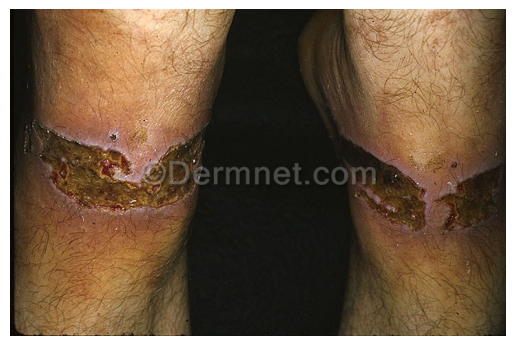

Image dimensions: 720 x 474


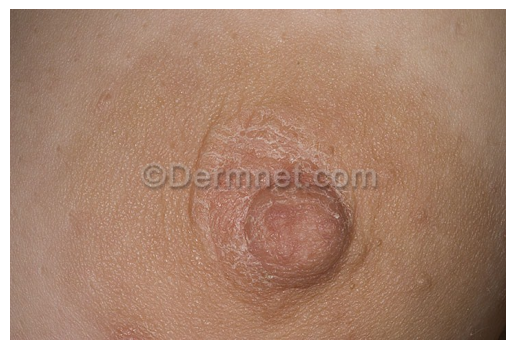

Image dimensions: 720 x 480


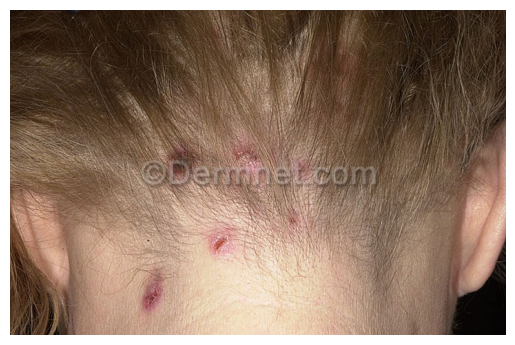

Image dimensions: 720 x 472


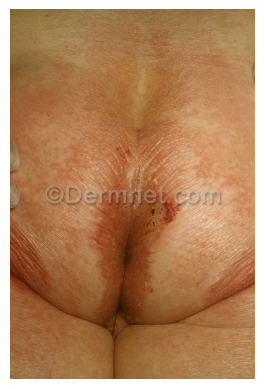

Image dimensions: 477 x 720


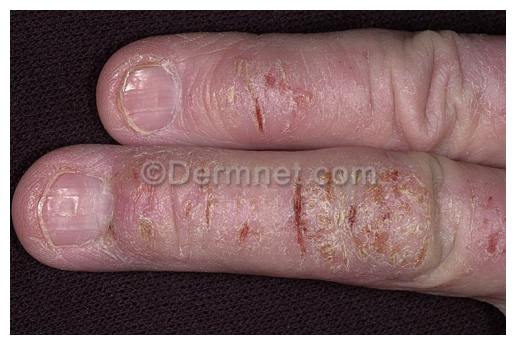

Image dimensions: 720 x 472


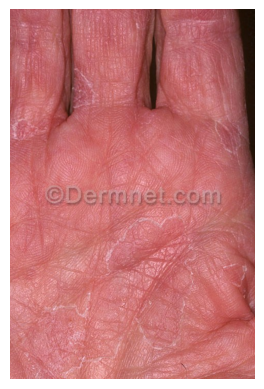

Image dimensions: 477 x 720


In [8]:
sample = '/kaggle/input/skin-diseases/kaggle/train/2. Ekzama'

files = os.listdir(sample)
count = 5
j = 0
for i in files:
    if j > count:
        break
    img_path = os.path.join(sample, i)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    width, height = img.size
    print(f"Image dimensions: {width} x {height}")
    j += 1

## Data Generator

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TrainDatagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
                                 )

ValidationDatagen = ImageDataGenerator(rescale = 1./255)

train_dir = '/kaggle/input/skin-diseases/kaggle/train'
val_dir = '/kaggle/input/skin-diseases/kaggle/val'

train = TrainDatagen.flow_from_directory(train_dir,
                                        shuffle = True,
                                        target_size = (224, 224), 
                                        class_mode='categorical',
                                        batch_size = 8
                                        )

validation = ValidationDatagen.flow_from_directory(val_dir,
                                        shuffle = True,
                                        target_size = (224, 224), 
                                        class_mode='categorical',
                                        batch_size = 8
                                        )

2024-06-27 15:35:09.810329: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 15:35:09.810435: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 15:35:09.952159: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 30909 images belonging to 6 classes.
Found 3923 images belonging to 6 classes.


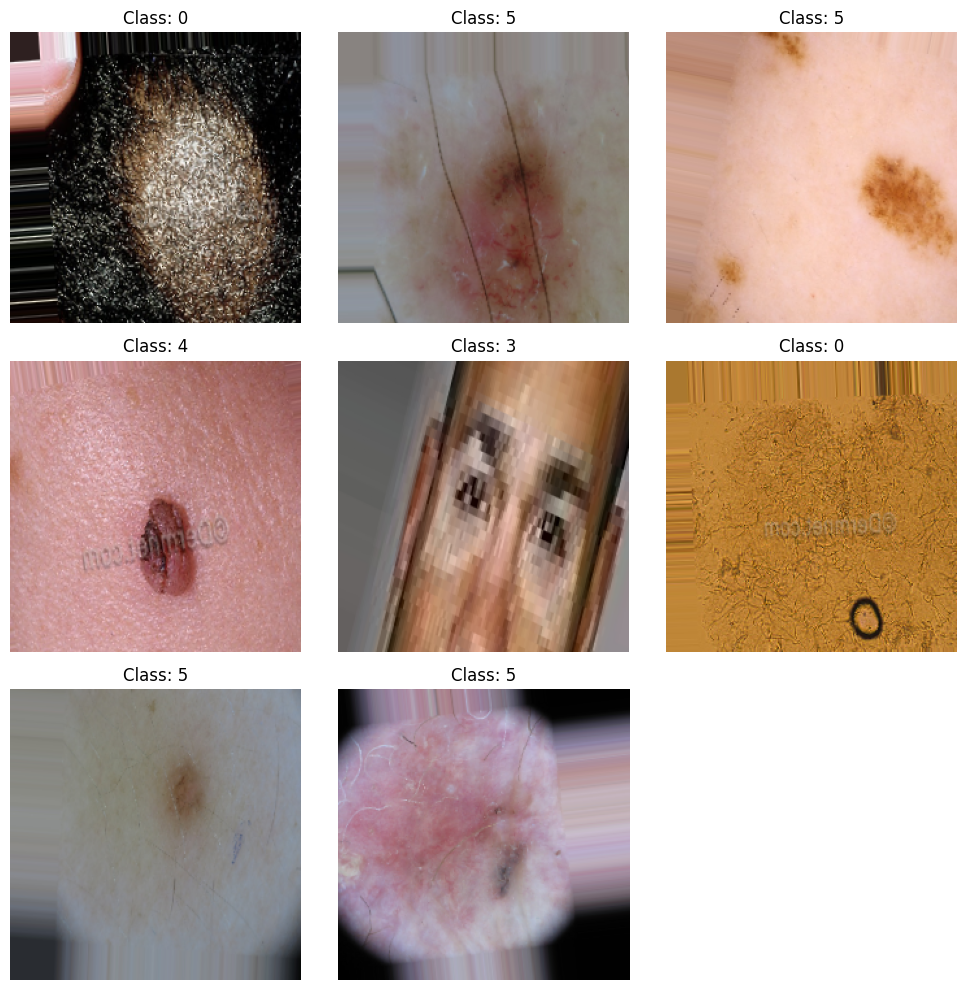

In [10]:
x_batch, y_batch = next(train)

plt.figure(figsize=(10, 10))
for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    class_index = np.argmax(y_batch[i])
    plt.title(f'Class: {class_index}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Callback

In [4]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

class Callback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.90:
            print(f"\nReached 90% accuracy at epoch {epoch+1}, stopping training!")
            self.model.stop_training = True

checkpoint_callback = ModelCheckpoint(filepath='model_checkpoint.weights.keras', 
                                      monitor='val_accuracy', 
                                      save_best_only=True,
                                      save_weights_only = False)

early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience=3, 
                                        restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', 
                                       factor=0.2, 
                                       patience=2, 
                                       min_lr=1e-6)

## Model

In [5]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

model = Sequential()

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation = 'relu'))
model.add(Dense(6, activation= 'softmax'))

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
hist = model.fit(train, epochs = 20, validation_data = validation, callbacks = [checkpoint_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   1/3864 ━━━━━━━━━━━━━━━━━━━━ 31:07:27 29s/step - accuracy: 0.1250 - loss: 2.0620

I0000 00:00:1719502604.492684      95 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3864/3864 ━━━━━━━━━━━━━━━━━━━━ 780s 195ms/step - accuracy: 0.5666 - loss: 1.0686 - val_accuracy: 0.6612 - val_loss: 0.8641 - learning_rate: 0.0010
Epoch 2/20
3864/3864 ━━━━━━━━━━━━━━━━━━━━ 491s 127ms/step - accuracy: 0.6659 - loss: 0.8461 - val_accuracy: 0.6913 - val_loss: 0.8137 - learning_rate: 0.0010
Epoch 3/20
3864/3864 ━━━━━━━━━━━━━━━━━━━━ 484s 125ms/step - accuracy: 0.6889 - loss: 0.7899 - val_accuracy: 0.7030 - val_loss: 0.7730 - learning_rate: 0.0010
Epoch 4/20
3864/3864 ━━━━━━━━━━━━━━━━━━━━ 486s 126ms/step - accuracy: 0.7005 - loss: 0.7642 - val_accuracy: 0.6967 - val_loss: 0.7760 - learning_rate: 0.0010
Epoch 5/20
3864/3864 ━━━━━━━━━━━━━━━━━━━━ 519s 134ms/step - accuracy: 0.7140 - loss: 0.7383 - val_accuracy: 0.7145 - val_loss: 0.7615 - learning_rate: 0.0010
Epoch 6/20
3864/3864 ━━━━━━━━━━━━━━━━━━━━ 489s 126ms/step - accuracy: 0.7205 - loss: 0.7162 - val_accuracy: 0.7260 - val_loss: 0.7157 - learning_rate: 0.0010
Epoch 7/20
3864/3864 ━━━━━━━━━━━━━━━━━━━━ 488s 126ms/step - acc

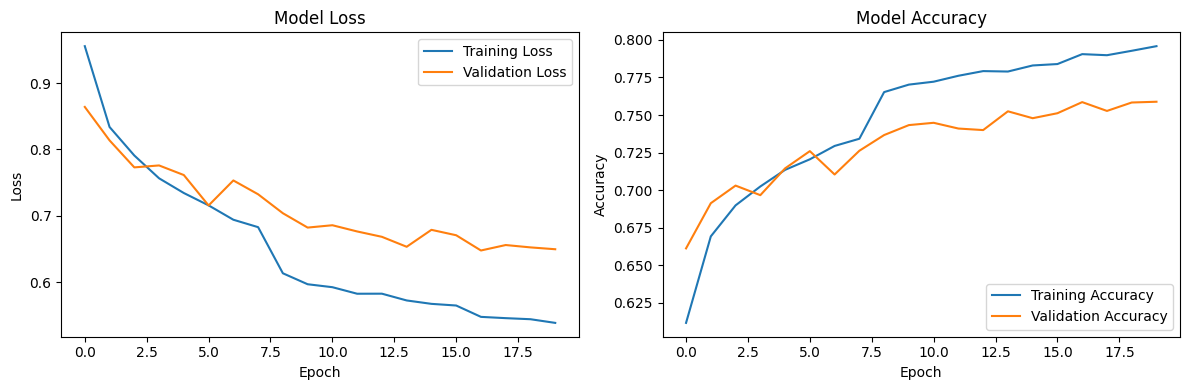

In [8]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [9]:
model.save('skindisease.keras')

In [12]:
test_dir = '/kaggle/input/skin-diseases/kaggle/test'

TestDatagen = ImageDataGenerator(rescale = 1./255)

test = TestDatagen.flow_from_directory(test_dir,
                                        shuffle = True,
                                        target_size = (224, 224), 
                                        class_mode='categorical',
                                        batch_size = 8
                                        )

Found 3928 images belonging to 6 classes.


## Test Accuracy

In [13]:
loss, accuracy = model.evaluate(test)
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

491/491 ━━━━━━━━━━━━━━━━━━━━ 45s 91ms/step - accuracy: 0.7604 - loss: 0.6112
Validation Loss: 0.6342
Validation Accuracy: 0.7553


In [ ]:
img_path = '/image_path'
img = image.load_img(img_path, target_size=(224, 224))

img_array = image.img_to_array(img)

img_array = np.expand_dims(img_array, axis=0)

img_array = img_array / 255.0

model = load_model('skindisease.keras')

predictions = model.predict(img_array)

class_names = ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions', 'Dermatofibroma', 'Melanoma', 'Melanocytic nevi', 'Vascular lesions']

predicted_class_index = np.argmax(predictions[0])

predicted_class_name = class_names[predicted_class_index]

print(f'Predicted class: {predicted_class_name} with probability {predictions[0][predicted_class_index]:.4f}')
